# **Хакатон. YAmarket_packaging**

## **Данные:**
Данные о заказах с указанием кол-ва товаров, их карготипе(типе продукции), таре в которую был спакован товар сборщиком. Есть цены и размеры тар.

## **Задача**
Построить модель, которая будет прогнозировать в какую тару(тип пакета или коробки) нужно поместить товар.

## **Ипользуемые библиотеки**
pandas, numpy, matplotlib, seaborn, sklearn, catboost, phik, xgboost, lightgbm

## **Cтатуса проекта**
Закончен

Загрузим необходимые модули.

In [4]:
!pip install openpyxl
!pip install category_encoders
!pip install association-metrics
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3930 sha256=f7e618f41ae5501faa8fce556b96853e541f7f3b8201d4d1165a0a71c693190d
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.

Подключим библиотеки.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import catboost
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split,RandomizedSearchCV
from sklearn.svm  import LinearSVC
from sklearn.svm import SVC
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
import shap
shap.initjs()

Загружаем данные.

In [6]:
!gdown 1HJWxQ9PhBTkrbXfaec9_Y9yb8S55g0Uc
!gdown 1ZO-ExOfiqtPvdPrvL_PiPTVS6xMmxb8V
!gdown 1IVAQFqiG3fgrBdESxAdq8Ka9DFuz71T9
!gdown 1a-d33-1H2iSbXVZsGLOMuQD61nxQ8sSp
!gdown 15fmCORJ0mwJzzUmOHJMCrpj1tDSLrheC
!gdown 1j8UYyJJi-0ukVW-8bMyhdYsxbFAWLtq5

Downloading...
From: https://drive.google.com/uc?id=1HJWxQ9PhBTkrbXfaec9_Y9yb8S55g0Uc
To: /content/cargotype_info.csv
100% 4.19k/4.19k [00:00<00:00, 5.14MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZO-ExOfiqtPvdPrvL_PiPTVS6xMmxb8V
To: /content/carton_price.xlsx
100% 5.77k/5.77k [00:00<00:00, 15.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IVAQFqiG3fgrBdESxAdq8Ka9DFuz71T9
To: /content/carton.csv
100% 495/495 [00:00<00:00, 1.42MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a-d33-1H2iSbXVZsGLOMuQD61nxQ8sSp
To: /content/data.csv
100% 58.6M/58.6M [00:01<00:00, 45.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=15fmCORJ0mwJzzUmOHJMCrpj1tDSLrheC
To: /content/sku_cargotypes.csv
100% 957M/957M [00:11<00:00, 85.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j8UYyJJi-0ukVW-8bMyhdYsxbFAWLtq5
To: /content/sku.csv
100% 350M/350M [00:05<00:00, 62.7MB/s]


In [7]:
# Сохраним данные из датасетов:
cargotype_info = pd.read_csv('/content/cargotype_info.csv', index_col=0, sep=',')
carton = pd.read_csv('/content/carton.csv', index_col=0, sep=',')
data = pd.read_csv('/content/data.csv', index_col=0, sep=',')
sku = pd.read_csv('/content/sku.csv', index_col=0, sep=',')
sku_cargotypes = pd.read_csv('/content/sku_cargotypes.csv', index_col=0, sep=',')
carton_price = pd.read_excel('/content/carton_price.xlsx', sheet_name="Chart data")

**Задача проекта** предсказать в какой тип коробки должен быть помещен заказ. У нас есть типы коробок, пакетиков, а также вариат без упаковки и в стрейч. Таким образом, мы решаем задачу **мультиклассовой классификации.**


**Целевой переменной** явлется **тип тары**(вариант упаковки).


**Признаки**, опираясь на коротрые модель будет принимать решение о выборе упаковки станут:
+ количество видов товаров в заказе
+ общий вес товаров в заказе
+ общий объем товаров в заказе
+ общий периметр товаров в заказе
+ столбцы с уникальными карготипами товаров из заказа

**Фильтрация данных перед загрузкой в модель для обучения:** мы решили остановиться на
+ 10 уникальных карготипов заказа
+ вес заказа до 20 кг
+ Лишь однажды в представленных данных был пакет YMB. Его мы также удалили из данных. Не возможно обучиться на таком кол-ве сведений.

**Варианты моделей** Отдельно обучили модели на выборке из товаров:
+ с 1 видом sku,
+ c 2мя видами sku
+ с 3мя и более видами sku.

Будем собирать итоговый файл для загрузки в модель.
В файле **sku** указаны размеры товара. Подсчитаем объем товара.

In [8]:
sku.head()

,sku,a,b,c
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0


In [9]:
sku['volume_sku'] = sku.a * sku.b * sku.c
sku.head()

,sku,a,b,c,volume_sku
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0,9548.0
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0,16240.0
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,5460.0
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0,312.0
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0,96768.0


В **sku_cargotypes** указаны карготипы товара. Переведем их в строки.

In [10]:
sku_cargotypes.head()

,sku,cargotype
0,4862bf0e760a593b13f3f2fcf822e533,290
1,4862bf0e760a593b13f3f2fcf822e533,901
2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,24ce9dba9f301ada55f60e25ee1498d2,290


In [11]:
sku_cargotypes['cargotype'] = sku_cargotypes['cargotype'].astype('str')

В файле **carton** тип упаковки идет в индексе. Вынесем его в отдельный столбец и переименуем.

In [12]:
carton.info()
carton.columns = carton.columns.str.lower()

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, YMA to MYE
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LENGTH         29 non-null     float64
 1   WIDTH          29 non-null     float64
 2   HEIGHT         29 non-null     float64
 3   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1)
memory usage: 1.1+ KB


In [13]:
carton = carton.reset_index()
carton.columns = ['selected_cartontype', 'length', 'width', 'height', 'displayrfpack']

В файле **carton_price** переименуем столбцы.

In [14]:
carton_price.columns = ['selected_cartontype', 'price_for_box']
carton_price.head()

,selected_cartontype,price_for_box
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722


Теперь к data Будем постепенно мерджить остальные файлы.

In [15]:
data_carton = data.merge(carton, how='left', on='selected_cartontype')
len(data)-len(data_carton)

0

In [16]:
data_carton_price = data_carton.merge(carton_price, how='left', on='selected_cartontype')
len(data_carton)-len(data_carton_price)

0

In [17]:
data_carton_price_sku = data_carton_price.merge(sku, how='left', on='sku')
len(data_carton_price_sku) - len(data_carton_price)

0

In [18]:
data_carton_price_sku.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,...,trackingid,length,width,height,displayrfpack,price_for_box,a,b,c,volume_sku
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,...,6c304d5c2815ccd2ba5046c101294c24,0.0,0.0,0.0,1.0,NaN,11.0,6.0,31.0,2046.0
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,...,6c304d5c2815ccd2ba5046c101294c24,0.0,0.0,0.0,1.0,NaN,11.0,6.0,31.0,2046.0
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,...,6c304d5c2815ccd2ba5046c101294c24,0.0,0.0,0.0,1.0,NaN,11.0,6.0,31.0,2046.0
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,...,6c304d5c2815ccd2ba5046c101294c24,0.0,0.0,0.0,1.0,NaN,11.0,6.0,31.0,2046.0
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,...,6c304d5c2815ccd2ba5046c101294c24,0.0,0.0,0.0,1.0,NaN,11.0,6.0,31.0,2046.0


Сверим равны ли selected_cartontype и selected_carton.

In [19]:
data_carton_price_sku.selected_cartontype.equals(data_carton_price_sku.selected_carton)

True

Равны. Значит selected_cartontype можно удалить как дубль.

In [20]:
data_carton_price_sku = data_carton_price_sku.drop('selected_cartontype', axis=1)
len(data_carton_price_sku)-len(data_carton_price_sku)

0

Сгруппируем карготипы для складских единиц.

In [21]:
sku_cargotypes_grouped = sku_cargotypes.groupby(['sku'])['cargotype'].apply(','.join).reset_index()

Будем соединять данные по заказам и типам товара. Считаем кол-во товаров в заказ, суммируем вес и размеры, а также объем.

In [22]:
agg_func = ({'selected_carton':'first','sku':'count', 'box_num': 'max', 'goods_wght': 'sum', 'a': 'sum', 'b': 'sum', 'c': 'sum', 'volume_sku': 'sum'})
table = data_carton_price_sku.groupby(['orderkey', 'sku'])[ 'selected_carton','sku', 'box_num', 'goods_wght', 'a', 'b', 'c', 'volume_sku',].agg(agg_func)
table.columns = [ 'selected_carton','counts_sku', 'box_num', 'goods_wght', 'a','b','c', 'volume_sku']
table =table.reset_index()
table


Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,orderkey,sku,selected_carton,counts_sku,box_num,goods_wght,a,b,c,volume_sku
0,00004fc4755eeb7e851e52ec91130fe4,4ca57504f6b7fe26f18a93bf368a381a,MYC,1,1,1.000,17.0,38.0,6.0,3876.000
1,00008e765c2d85abfa9c97563afd98ef,6c322b3bf34b132de6bbf7e1978e48df,MYB,1,1,0.135,19.0,3.0,5.0,285.000
2,0000c268eb1be1dd5b8c1a032f7318fc,4557dfce2a53e74186156d84b44d0c9c,MYC,3,1,0.270,75.0,21.0,51.0,8925.000
3,0000fc4c7acac6e89f82392b90e47a27,4ac273ebe2c3a48830ebddbdac5e74fe,MYB,1,1,0.200,8.0,6.0,13.0,624.000
4,0000fc4c7acac6e89f82392b90e47a27,93c76085979851f91f4e276555c84efc,MYB,1,1,0.200,6.0,6.0,22.0,792.000
...,...,...,...,...,...,...,...,...,...,...
228061,fffe13683b35336a4c1bb061f479f05b,1094f2dd6ccc9e6481333e7dba5b8fed,MYA,1,1,0.016,9.0,1.5,9.0,121.500
228062,ffff1e5d7f5b52f28d733ba01a4589b9,007f5daf1d22df8ca9b9d7e6f954d8cc,MYC,1,1,0.150,25.0,3.0,14.0,1050.000
228063,ffff1f0a51126b373f36d7733a5ddb0f,87279f142e7b1eee97e7e7213332432a,MYC,2,1,0.408,29.6,8.2,43.8,2657.784
228064,ffff748210310fffe23e3ade55d26401,80a44cb584e1b501c3961f363b45a64f,MYA,1,1,0.030,5.0,6.0,4.0,120.000


In [23]:
table

,orderkey,sku,selected_carton,counts_sku,box_num,goods_wght,a,b,c,volume_sku
0,00004fc4755eeb7e851e52ec91130fe4,4ca57504f6b7fe26f18a93bf368a381a,MYC,1,1,1.000,17.0,38.0,6.0,3876.000
1,00008e765c2d85abfa9c97563afd98ef,6c322b3bf34b132de6bbf7e1978e48df,MYB,1,1,0.135,19.0,3.0,5.0,285.000
2,0000c268eb1be1dd5b8c1a032f7318fc,4557dfce2a53e74186156d84b44d0c9c,MYC,3,1,0.270,75.0,21.0,51.0,8925.000
3,0000fc4c7acac6e89f82392b90e47a27,4ac273ebe2c3a48830ebddbdac5e74fe,MYB,1,1,0.200,8.0,6.0,13.0,624.000
4,0000fc4c7acac6e89f82392b90e47a27,93c76085979851f91f4e276555c84efc,MYB,1,1,0.200,6.0,6.0,22.0,792.000
...,...,...,...,...,...,...,...,...,...,...
228061,fffe13683b35336a4c1bb061f479f05b,1094f2dd6ccc9e6481333e7dba5b8fed,MYA,1,1,0.016,9.0,1.5,9.0,121.500
228062,ffff1e5d7f5b52f28d733ba01a4589b9,007f5daf1d22df8ca9b9d7e6f954d8cc,MYC,1,1,0.150,25.0,3.0,14.0,1050.000
228063,ffff1f0a51126b373f36d7733a5ddb0f,87279f142e7b1eee97e7e7213332432a,MYC,2,1,0.408,29.6,8.2,43.8,2657.784
228064,ffff748210310fffe23e3ade55d26401,80a44cb584e1b501c3961f363b45a64f,MYA,1,1,0.030,5.0,6.0,4.0,120.000


In [24]:
table.columns

Index(['orderkey', 'sku', 'selected_carton', 'counts_sku', 'box_num',
       'goods_wght', 'a', 'b', 'c', 'volume_sku'],
      dtype='object')

Добавим данные по карготипам товаров.

In [25]:
table1 = table.merge(sku_cargotypes_grouped, how='left', on='sku')
len(table1)-len(table)

0

In [26]:
table1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228066 entries, 0 to 228065
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   orderkey         228066 non-null  object 
 1   sku              228066 non-null  object 
 2   selected_carton  228066 non-null  object 
 3   counts_sku       228066 non-null  int64  
 4   box_num          228066 non-null  int64  
 5   goods_wght       228066 non-null  float64
 6   a                228066 non-null  float64
 7   b                228066 non-null  float64
 8   c                228066 non-null  float64
 9   volume_sku       228066 non-null  float64
 10  cargotype        219319 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 20.9+ MB


А теперь будем агрегировать инофрмацию по самому заказу.

In [27]:
agg_func = ({'selected_carton':'first','counts_sku':'count', 'box_num': 'max', 'goods_wght': 'sum', 'a': 'sum','b': 'sum', 'c': 'sum', 'volume_sku': 'sum','cargotype':'sum'})
table2 = pd.DataFrame(table1.groupby(['orderkey'])['selected_carton', 'counts_sku', 'box_num', 'goods_wght', 'a', 'b', 'c',  'volume_sku','cargotype'].agg(agg_func)).reset_index()
table2

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,orderkey,selected_carton,counts_sku,box_num,goods_wght,a,b,c,volume_sku,cargotype
0,00004fc4755eeb7e851e52ec91130fe4,MYC,1,1,1.000,17.0,38.0,6.0,3876.000,"290,410,750,780"
1,00008e765c2d85abfa9c97563afd98ef,MYB,1,1,0.135,19.0,3.0,5.0,285.000,"290,410,440,441,480,690"
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,1,1,0.270,75.0,21.0,51.0,8925.000,"290,340,410,720,750,780"
3,0000fc4c7acac6e89f82392b90e47a27,MYB,2,1,0.400,14.0,12.0,35.0,1416.000,"290,641,690290,641,690"
4,0001963724fa4cc12d4f025056085633,YMW,2,1,2.224,120.0,140.0,80.0,12300.000,"290,410,720,750,780,920290,340,410,720,750,780"
...,...,...,...,...,...,...,...,...,...,...
159894,fffe13683b35336a4c1bb061f479f05b,MYA,1,1,0.016,9.0,1.5,9.0,121.500,"290,671,690,950"
159895,ffff1e5d7f5b52f28d733ba01a4589b9,MYC,1,1,0.150,25.0,3.0,14.0,1050.000,290
159896,ffff1f0a51126b373f36d7733a5ddb0f,MYC,1,1,0.408,29.6,8.2,43.8,2657.784,"290,340,400,410,480,485,520"
159897,ffff748210310fffe23e3ade55d26401,MYA,1,1,0.030,5.0,6.0,4.0,120.000,"290,340,691,901"


Разобъем карготипы на отдельные столбцы.

In [28]:
table2.cargotype = [list(set(str(x).split(','))) for x in table2.cargotype]
table3 = pd.DataFrame(table2['cargotype'].tolist()).add_prefix('cargo_')
table = pd.concat([table2, table3], axis=1)
table = table.drop(['cargotype'], axis=1)
table =table.reset_index()
table.head()

,index,orderkey,selected_carton,counts_sku,box_num,goods_wght,a,b,c,volume_sku,...,cargo_22,cargo_23,cargo_24,cargo_25,cargo_26,cargo_27,cargo_28,cargo_29,cargo_30,cargo_31
0,0,00004fc4755eeb7e851e52ec91130fe4,MYC,1,1,1.000,17.0,38.0,6.0,3876.0,...,None,None,None,None,None,None,None,None,None,None
1,1,00008e765c2d85abfa9c97563afd98ef,MYB,1,1,0.135,19.0,3.0,5.0,285.0,...,None,None,None,None,None,None,None,None,None,None
2,2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,1,1,0.270,75.0,21.0,51.0,8925.0,...,None,None,None,None,None,None,None,None,None,None
3,3,0000fc4c7acac6e89f82392b90e47a27,MYB,2,1,0.400,14.0,12.0,35.0,1416.0,...,None,None,None,None,None,None,None,None,None,None
4,4,0001963724fa4cc12d4f025056085633,YMW,2,1,2.224,120.0,140.0,80.0,12300.0,...,None,None,None,None,None,None,None,None,None,None


Избавимся от лишних символов, которые остались после группировки и преобразования списков до унимкальных значений. Преобразуем данные к формату float.

In [29]:
cargos = [ 'cargo_0', 'cargo_1', 'cargo_2', 'cargo_3', 'cargo_4',
       'cargo_5', 'cargo_6', 'cargo_7', 'cargo_8', 'cargo_9', 'cargo_10',
       'cargo_11', 'cargo_12', 'cargo_13', 'cargo_14', 'cargo_15', 'cargo_16',
       'cargo_17', 'cargo_18', 'cargo_19', 'cargo_20', 'cargo_21', 'cargo_22',
       'cargo_23', 'cargo_24', 'cargo_25', 'cargo_26', 'cargo_27', 'cargo_28',
       'cargo_29', 'cargo_30', 'cargo_31']
for cargo in cargos:
    table[cargo] =  table[cargo].replace(r"[^\d\.]", '', regex=True)
    table[cargo] = table[cargo].astype(float)

С учетом нашей идеи о том, что будем использовать лишь 3 ида коробок, проводим замену таргета.

In [30]:
table = table.replace({'selected_carton' : { 'YMC' : 'YMA', 'YMF' : 'YMB', 'YMW' : 'YMB', 'YMN' : 'YMB', 'YMG' : 'YMB', 'YME' : 'YMB', 'YMX' : 'YMB', 'YML' : 'YMC'}})

Там, где у нас нет инфо по карготипу, укажем 0.

In [31]:
table = table.fillna(0)

Посмотрим на вес товаров в заказе.

<Axes: >

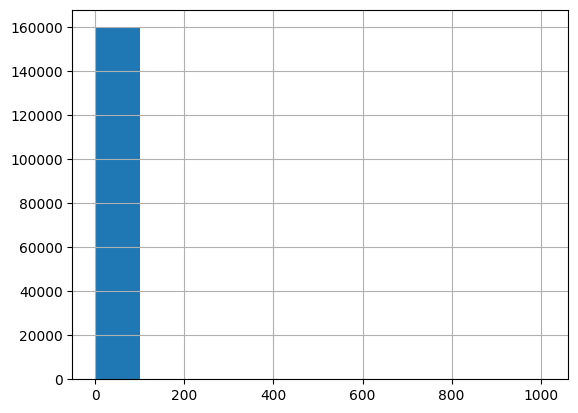

In [32]:
table.goods_wght.hist()

Рассмотрим категрию до 20кг.

<Axes: >

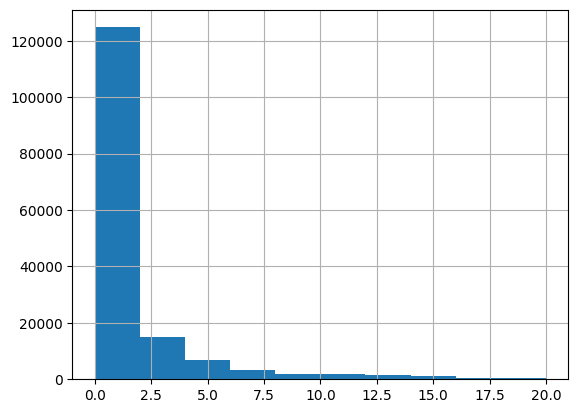

In [33]:
table[table.goods_wght<20]['goods_wght'].hist()

In [34]:
len(table[table.goods_wght<20])/len(table)

0.9835458633262247

98% заказов идут с весом до 20 кг. Сосредоточимся на них. Из таргета исключим YMB(такой 1 случай был).

In [35]:
table = table[table.goods_wght<20]
table = table[table.selected_carton!='YMB']

In [36]:
table[['cargo_0', 'cargo_1', 'cargo_2', 'cargo_3', 'cargo_4','cargo_5', 'cargo_6', 'cargo_7', 'cargo_8', 'cargo_9', 'cargo_10','cargo_11', 'cargo_12', 'cargo_13', 'cargo_14', 'cargo_15', 'cargo_16', 'cargo_17', 'cargo_18', 'cargo_19', 'cargo_20', 'cargo_21', 'cargo_22', 'cargo_23', 'cargo_24', 'cargo_25', 'cargo_26', 'cargo_27', 'cargo_28', 'cargo_29', 'cargo_30', 'cargo_31']].describe()

,cargo_0,cargo_1,cargo_2,cargo_3,cargo_4,cargo_5,cargo_6,cargo_7,cargo_8,cargo_9,...,cargo_22,cargo_23,cargo_24,cargo_25,cargo_26,cargo_27,cargo_28,cargo_29,cargo_30,cargo_31
count,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,1.442390e+05,...,1.442390e+05,1.442390e+05,144239.000000,144239.000000,144239.000000,144239.000000,144239.000000,144239.000000,144239.000000,144239.000000
mean,2.012564e+66,2.012564e+24,1.344029e+10,2.364016e+15,4.785740e+15,6.614502e+09,2.614443e+07,4.785751e+12,4.893702e+06,7.526135e+06,...,1.378322e+01,1.366621e+01,5.424712,6.665465,0.008181,6.622966,0.004791,0.003362,0.002149,0.002843
std,7.643480e+68,7.643480e+26,3.185671e+12,8.960049e+17,1.817567e+18,2.502163e+12,4.135402e+09,1.817567e+15,1.817587e+09,2.192128e+09,...,3.218039e+03,3.662943e+03,2054.094332,2528.489493,2.296940,2515.323684,1.819436,1.277028,0.816245,1.079549
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.900000e+02,2.900000e+02,2.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.900000e+02,2.900000e+02,4.410000e+02,4.100000e+02,2.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.600000e+02,6.400000e+02,6.920000e+02,6.900000e+02,5.200000e+02,4.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.902903e+71,2.902903e+29,9.502903e+14,3.402913e+20,6.902903e+20,9.502903e+14,6.902903e+11,6.902903e+17,6.902903e+11,7.802903e+11,...,1.011290e+06,1.011290e+06,780120.000000,960290.000000,770.000000,955290.000000,691.000000,485.000000,310.000000,410.000000


Сузим кол-во карготипов до 10. Дальше большая часть значений - нули.



In [37]:
table = table.drop([ 'cargo_11', 'cargo_12', 'cargo_13', 'cargo_14', 'cargo_15','cargo_16', 'cargo_17', 'cargo_18', 'cargo_19', 'cargo_20', 'cargo_21','cargo_22', 'cargo_23', 'cargo_24', 'cargo_25', 'cargo_26', 'cargo_27', 'cargo_28', 'cargo_29', 'cargo_30', 'cargo_31'], axis=1)

Посмотрим на распределение таргета.

<Axes: xlabel='Count', ylabel='selected_carton'>

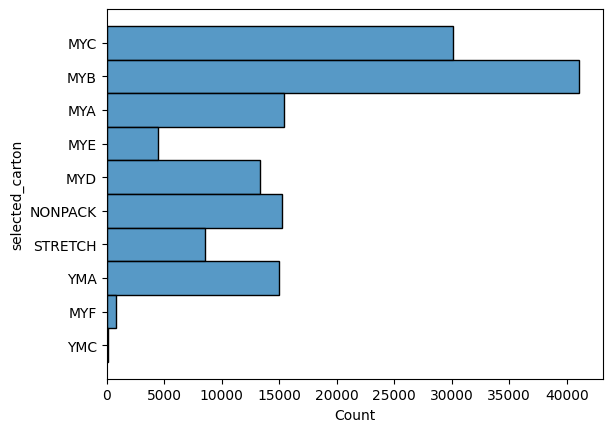

In [38]:
sns.histplot(data=table, y="selected_carton")

**Вывод по распределению таргета**
+ есть дисбаланс классов
+ часть коробок(например YMB, YMC) толком не представлена в данных. Значит, модель будет ошибаться на таких заказах.
+ нужно ссобрать больше данных по заказам с большим объемам для достижения необходимых уровней точности.

Разобъем заказы по кол-ву типов sku

In [39]:
table_1 =table[table.counts_sku==1]
table_2 =table[table.counts_sku==2]
table_3 =table[table.counts_sku>=3]

In [40]:
table_1['P'] = table_1['a']*table_1['b']
table_2['P'] = table_2['a']*table_2['b']
table_3['P'] = table_3['a']*table_3['b']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
X1 = table_1.drop(['selected_carton', 'orderkey'], axis=1)
y1 = table_1['selected_carton']
X2 = table_2.drop(['selected_carton', 'orderkey'], axis=1)
y2 = table_2['selected_carton']
X3 = table_3.drop(['selected_carton', 'orderkey'], axis=1)
y3 = table_3['selected_carton']

In [42]:
X1 = X1[['counts_sku', 'goods_wght', 'volume_sku', 'P', 'cargo_0', 'cargo_1', 'cargo_2',
       'cargo_3', 'cargo_4', 'cargo_5', 'cargo_6', 'cargo_7', 'cargo_8',
       'cargo_9', 'cargo_10']]
X2 = X2[['counts_sku', 'goods_wght', 'volume_sku', 'P', 'cargo_0', 'cargo_1', 'cargo_2',
       'cargo_3', 'cargo_4', 'cargo_5', 'cargo_6', 'cargo_7', 'cargo_8',
       'cargo_9', 'cargo_10']]
X3 = X3[['counts_sku', 'goods_wght', 'volume_sku', 'P', 'cargo_0', 'cargo_1', 'cargo_2',
       'cargo_3', 'cargo_4', 'cargo_5', 'cargo_6', 'cargo_7', 'cargo_8',
       'cargo_9', 'cargo_10']]

Разобъем данные на тренировочную и тестовую выборки.

In [43]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state=911)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=911)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.25, random_state=911)

In [44]:
le = LabelEncoder()
y_train1 = le.fit_transform(y_train1)
y_test1 = le.transform(y_test1)
inverse_transform_train1 = le.inverse_transform(y_train1)
inverse_transform_test1 = le.inverse_transform(y_test1)
le = LabelEncoder()
y1 = le.fit_transform(y1)
inverse_transform_y1 = le.inverse_transform(y1)

In [45]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train2)
y_test2 = le.transform(y_test2)
inverse_transform_train2 = le.inverse_transform(y_train2)
inverse_transform_test2 = le.inverse_transform(y_test2)
le = LabelEncoder()
y2 = le.fit_transform(y2)
inverse_transform_y2 = le.inverse_transform(y2)

In [46]:
le = LabelEncoder()
y_train3 = le.fit_transform(y_train3)
y_test3 = le.transform(y_test3)
inverse_transform_train3 = le.inverse_transform(y_train3)
inverse_transform_test3 = le.inverse_transform(y_test3)
le = LabelEncoder()
y3 = le.fit_transform(y3)
inverse_transform_y3 = le.inverse_transform(y3)

В карготипах опечатки. Исключим их.

In [47]:
cargos = ['cargo_0', 'cargo_1', 'cargo_2','cargo_3', 'cargo_4', 'cargo_5', 'cargo_6', 'cargo_7', 'cargo_8','cargo_9', 'cargo_10']
for col in cargos:
    X1[col] = [0 if x>10000 else x for x in X1[col]]
    X2[col] = [0 if x>10000 else x for x in X2[col]]
    X3[col] = [0 if x>10000 else x for x in X3[col]]

**Построение baseline**
Для baseline-модели мы сделаем следующее:

1. масштабируем все признаки с помощью StandardScaler
2. обучим на кросс-валидации разные типы модели, подберем лучшие:
+ SVC(),
+ LinearSVC(),
+ DecisionTreeClassifier(),
+ RandomForestClassifier(),
+ AdaBoostClassifier(),
+ GradientBoostingClassifier(),
+ CatBoostClassifier(),
+ lgb.LGBMClassifier(),
+ xgb.XGBClassifier()

In [48]:
def TotalTransportVolume(y_pred_, inverse_transform_test_):
    business = pd.DataFrame()
    business['y_test'] = inverse_transform_test_
    business = business.merge(carton[['selected_cartontype','volume_cartontype']],left_on='y_test',right_on='selected_cartontype', how='left')
    business.columns = ['y_test', 'cartontype', 'volume_cartontype_test']
    business = business[['y_test', 'volume_cartontype_test']]
    business['y_pred'] = le.inverse_transform(y_pred_)
    business = business.merge(carton[['selected_cartontype','volume_cartontype']],left_on='y_pred',right_on='selected_cartontype', how='left')
    business.columns = ['y_test', 'volume_cartontype_test','y_pred', 'selected_cartontype', 'volume_cartontype_pred']
    business = business[['y_test', 'volume_cartontype_test','y_pred', 'volume_cartontype_pred']]
    return business, print(f'Алгоритм предсказал упаковки на объем: {round(business["volume_cartontype_pred"].sum(),0)} а на y_test был {round(business["volume_cartontype_test"].sum(),0)}, разница {100 - round(business["volume_cartontype_pred"].sum()/business["volume_cartontype_test"].sum()*100,0)}%')


Попробуем разные варианты на кросс-валидации.

# Обучим модель для заказов со sku больше 3

In [49]:
%%time
list_pipelines_ = []
mean_score_ = []
classifiers = [
    KNeighborsClassifier(11),
    SVC(kernel="rbf", random_state=911),
    LinearSVC(random_state=911),
    DecisionTreeClassifier(random_state=911),
    RandomForestClassifier(random_state=911),
    AdaBoostClassifier(random_state=911),
    GradientBoostingClassifier(random_state=911),
    CatBoostClassifier(random_seed=911, loss_function='MultiClass', verbose=False),
    lgb.LGBMClassifier(objective='multiclass', random_state=911),
    xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric=['merror','mlogloss'], seed=911)

    ]
scalers = [StandardScaler()]

for classifier in classifiers:
    for scaler in scalers:
        p1_ = Pipeline([
        ('scaler_', scaler),
        ('model_', classifier)
        ])
        scores_ = cross_val_score(p1_, X3, y3)
        print(scaler)
        print(classifier)
        print("model score: %.3f" % scores_.mean())
        print()
        mean_score_.append(scores_.mean())
        list_pipelines_.append(str(classifier) + str(scaler))

StandardScaler()
KNeighborsClassifier(n_neighbors=11)
model score: 0.326

StandardScaler()
SVC(random_state=911)
model score: 0.359



Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


StandardScaler()
LinearSVC(random_state=911)
model score: 0.330

StandardScaler()
DecisionTreeClassifier(random_state=911)
model score: 0.291

StandardScaler()
RandomForestClassifier(random_state=911)
model score: 0.398

StandardScaler()
AdaBoostClassifier(random_state=911)
model score: 0.324

StandardScaler()
GradientBoostingClassifier(random_state=911)
model score: 0.402

StandardScaler()
model score: 0.392

StandardScaler()
LGBMClassifier(objective='multiclass', random_state=911)
model score: 0.394

StandardScaler()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=Non

,0
KNeighborsClassifier(n_neighbors=11)StandardScaler(),0.325509
SVC(random_state=911)StandardScaler(),0.359338
LinearSVC(random_state=911)StandardScaler(),0.329998
DecisionTreeClassifier(random_state=911)StandardScaler(),0.291220
RandomForestClassifier(random_state=911)StandardScaler(),0.398344
AdaBoostClassifier(random_state=911)StandardScaler(),0.324476
GradientBoostingClassifier(random_state=911)StandardScaler(),0.401913
<catboost.core.CatBoostClassifier object at 0x7f92d4e235e0>StandardScaler(),0.392245
"LGBMClassifier(objective='multiclass', random_state=911)StandardScaler()",0.394431
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=['merror', 'mlogloss'],\n feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, n_estimators=100, n_jobs=None,\n num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)StandardScaler()",0.396043


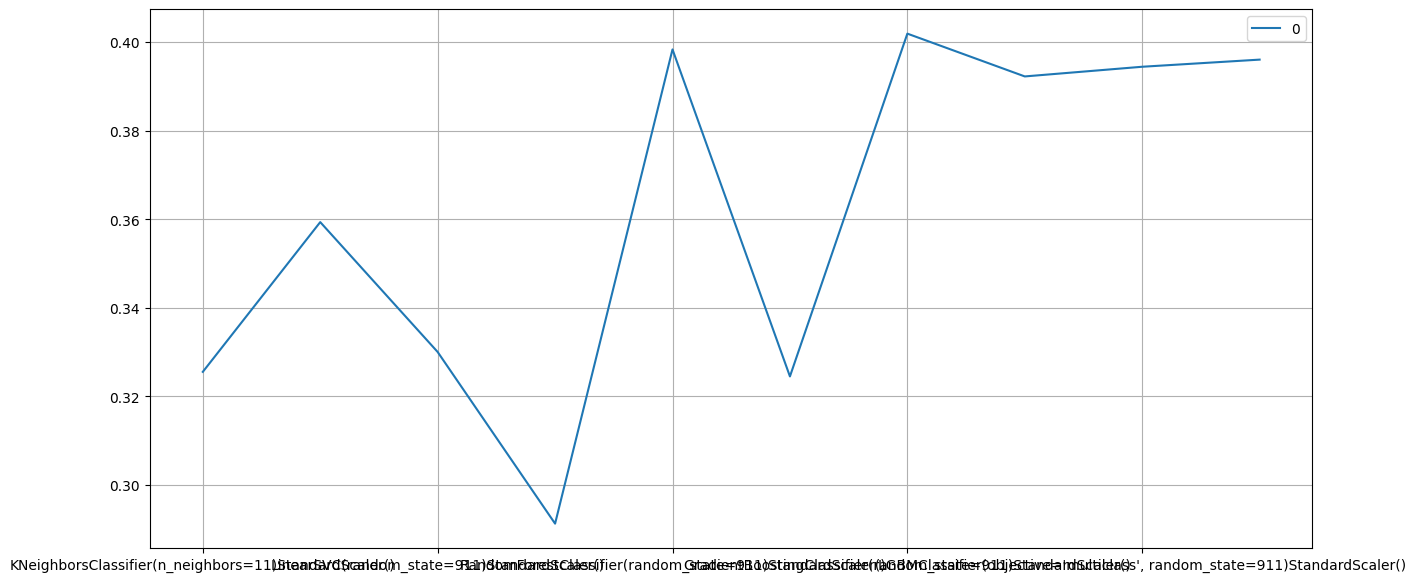

In [50]:
results=pd.DataFrame(data=mean_score_,index=list_pipelines_)
results.plot(figsize=(15,7))
plt.grid()
results

In [51]:
max_value = max(mean_score_)
max_index = mean_score_. index(max_value)
max_index
results.iloc[max_index]

0    0.401913
Name: GradientBoostingClassifier(random_state=911)StandardScaler(), dtype: float64

**Вывод по выборке со sku больше 3** лучшая модель  GradientBoostingClassifier

 # Обучим модель для заказов со sku =2

In [52]:
%%time
list_pipelines_ = []
mean_score_ = []
classifiers = [
    KNeighborsClassifier(11),
    SVC(kernel="rbf", random_state=911),
    LinearSVC(random_state=911),
    DecisionTreeClassifier(random_state=911),
    RandomForestClassifier(random_state=911),
    AdaBoostClassifier(random_state=911),
    GradientBoostingClassifier(random_state=911),
    CatBoostClassifier(random_seed=911, loss_function='MultiClass', verbose=False),
    lgb.LGBMClassifier(objective='multiclass', random_state=911),
    xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric=['merror','mlogloss'], seed=911)
    ]
scalers = [StandardScaler()]

for classifier in classifiers:
    for scaler in scalers:
        p1_ = Pipeline([
        ('scaler_', scaler),
        ('model_', classifier)
        ])
        scores_ = cross_val_score(p1_, X2, y2)
        print(scaler)
        print(classifier)
        print("model score: %.3f" % scores_.mean())
        print()
        mean_score_.append(scores_.mean())
        list_pipelines_.append(str(classifier) + str(scaler))

StandardScaler()
KNeighborsClassifier(n_neighbors=11)
model score: 0.375

StandardScaler()
SVC(random_state=911)
model score: 0.396



Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


StandardScaler()
LinearSVC(random_state=911)
model score: 0.321

StandardScaler()
DecisionTreeClassifier(random_state=911)
model score: 0.325

StandardScaler()
RandomForestClassifier(random_state=911)
model score: 0.423

StandardScaler()
AdaBoostClassifier(random_state=911)
model score: 0.183

StandardScaler()
GradientBoostingClassifier(random_state=911)
model score: 0.439

StandardScaler()
model score: 0.444

StandardScaler()
LGBMClassifier(objective='multiclass', random_state=911)
model score: 0.433

StandardScaler()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=Non

,0
KNeighborsClassifier(n_neighbors=11)StandardScaler(),0.375130
SVC(random_state=911)StandardScaler(),0.396047
LinearSVC(random_state=911)StandardScaler(),0.321449
DecisionTreeClassifier(random_state=911)StandardScaler(),0.324973
RandomForestClassifier(random_state=911)StandardScaler(),0.423494
AdaBoostClassifier(random_state=911)StandardScaler(),0.182941
GradientBoostingClassifier(random_state=911)StandardScaler(),0.438865
<catboost.core.CatBoostClassifier object at 0x7f92d4f5c6a0>StandardScaler(),0.444354
"LGBMClassifier(objective='multiclass', random_state=911)StandardScaler()",0.432856
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=['merror', 'mlogloss'],\n feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, n_estimators=100, n_jobs=None,\n num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)StandardScaler()",0.434531


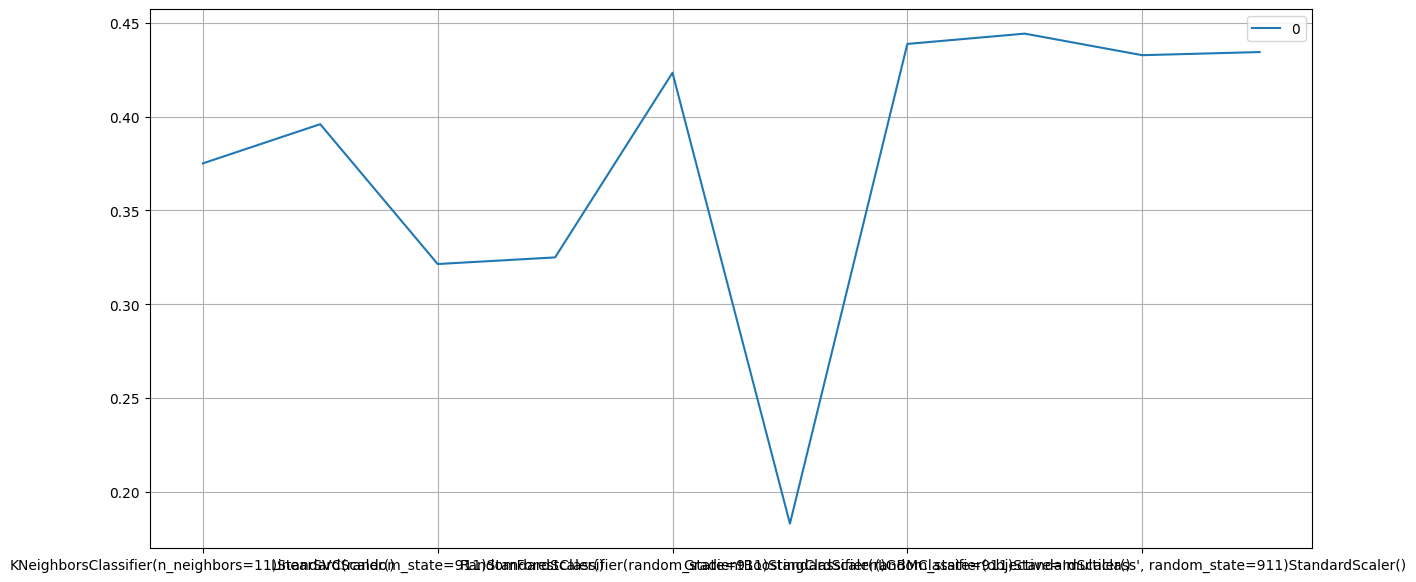

In [53]:
results=pd.DataFrame(data=mean_score_,index=list_pipelines_)
results.plot(figsize=(15,7))
plt.grid()
results

In [54]:
max_value = max(mean_score_)
max_index = mean_score_. index(max_value)
max_index
results.iloc[max_index]

0    0.444354
Name: <catboost.core.CatBoostClassifier object at 0x7f92d4f5c6a0>StandardScaler(), dtype: float64

**Вывод по выборке со sku 2 видов** лучшая модель  GradientBoostingClassifier

#Обучим модель для заказов со sku =1

In [55]:
%%time
list_pipelines_ = []
mean_score_ = []
classifiers = [
    KNeighborsClassifier(11),
    SVC(kernel="rbf", random_state=911),
    LinearSVC(random_state=911),
    DecisionTreeClassifier(random_state=911),
    RandomForestClassifier(random_state=911),
    AdaBoostClassifier(random_state=911),
    GradientBoostingClassifier(random_state=911),
    CatBoostClassifier(random_seed=911, loss_function='MultiClass', verbose=False),
    lgb.LGBMClassifier(objective='multiclass', random_state=911),
    xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric=['merror','mlogloss'], seed=911)

    ]
scalers = [StandardScaler()]

for classifier in classifiers:
    for scaler in scalers:
        p1_ = Pipeline([
        ('scaler_', scaler),
        ('model_', classifier)
        ])
        scores_ = cross_val_score(p1_, X1, y1)
        print(scaler)
        print(classifier)
        print("model score: %.3f" % scores_.mean())
        print()
        mean_score_.append(scores_.mean())
        list_pipelines_.append(str(classifier) + str(scaler))



StandardScaler()
KNeighborsClassifier(n_neighbors=11)
model score: 0.533

StandardScaler()
SVC(random_state=911)
model score: 0.474



Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


StandardScaler()
LinearSVC(random_state=911)
model score: 0.395

StandardScaler()
DecisionTreeClassifier(random_state=911)
model score: 0.505

StandardScaler()
RandomForestClassifier(random_state=911)
model score: 0.541

StandardScaler()
AdaBoostClassifier(random_state=911)
model score: 0.340

StandardScaler()
GradientBoostingClassifier(random_state=911)
model score: 0.534

StandardScaler()
model score: 0.554

StandardScaler()
LGBMClassifier(objective='multiclass', random_state=911)
model score: 0.534

StandardScaler()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=Non

,0
KNeighborsClassifier(n_neighbors=11)StandardScaler(),0.532721
SVC(random_state=911)StandardScaler(),0.474011
LinearSVC(random_state=911)StandardScaler(),0.394767
DecisionTreeClassifier(random_state=911)StandardScaler(),0.504804
RandomForestClassifier(random_state=911)StandardScaler(),0.541102
AdaBoostClassifier(random_state=911)StandardScaler(),0.339852
GradientBoostingClassifier(random_state=911)StandardScaler(),0.534116
<catboost.core.CatBoostClassifier object at 0x7f9259898580>StandardScaler(),0.554177
"LGBMClassifier(objective='multiclass', random_state=911)StandardScaler()",0.534209
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=['merror', 'mlogloss'],\n feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, n_estimators=100, n_jobs=None,\n num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)StandardScaler()",0.556528


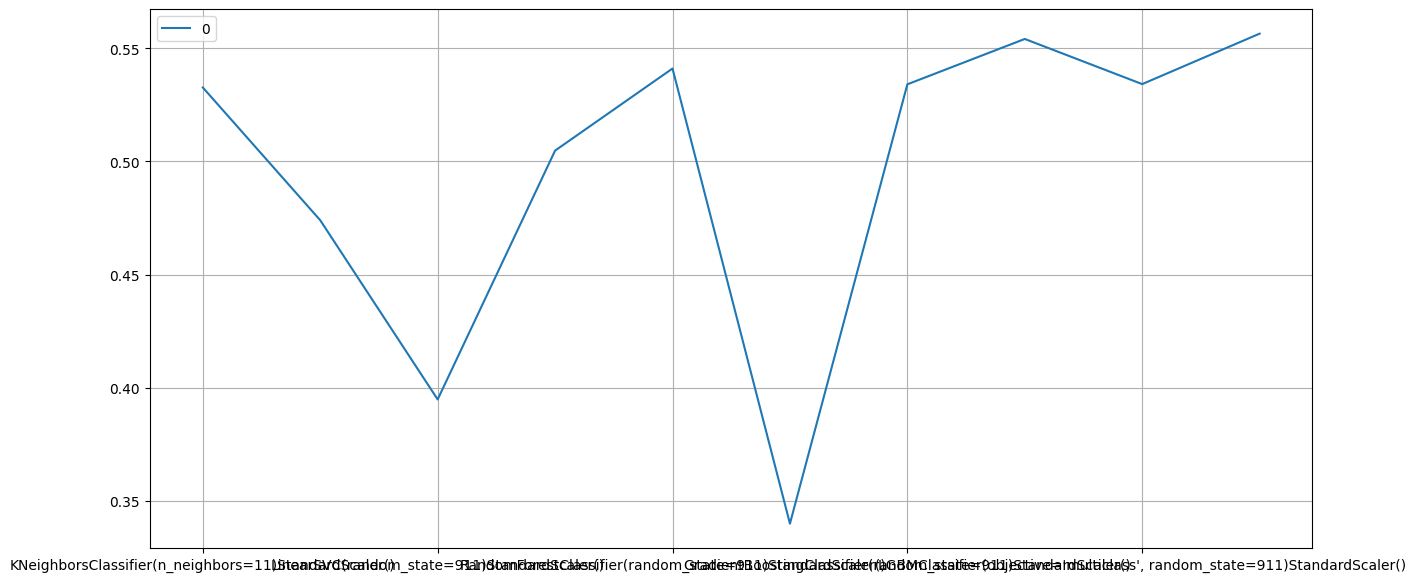

In [56]:
results=pd.DataFrame(data=mean_score_,index=list_pipelines_)
results.plot(figsize=(15,7))
plt.grid()
results

In [57]:
max_value = max(mean_score_)
max_index = mean_score_. index(max_value)
max_index
results.iloc[max_index]

0    0.556528
Name: XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=['merror', 'mlogloss'],\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n              max_leaves=None, min_child_weight=None, missing=nan,\n              monotone_constraints=None, n_estimators=100, n_jobs=None,\n              num_class=11, num_parallel_tree=None, objective='multi:softmax', ...)StandardScaler(), dtype: float64

**Вывод по выборке с 1 типом sku** лучшая модель  XGBClassifier



**Вывод по Baseline:**
по полученым результатам получается, что на выборках с 2 и 3мя видами товаров лучше работает CatBoostClassifier. А на выборке с 1 видом товара, лучше справился XGBClassifier.

Их и запускаем с подбоом параметров и обсчетом результата по метрикам.

**Точная настройка модели с подбором гипер-параметров**

**Модель для заказов со sku больше 3**

In [58]:
p1_jm = Pipeline([
    ('scaler_', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=911))
    ])
param_grid = {'model__learning_rate' : [0.01,0.1]}


grid = GridSearchCV(p1_jm, param_grid)
grid.fit(X_train3, y_train3)
model3 = grid.best_estimator_
y_pred3 = model3.predict(X_test3)
labels3 = le.inverse_transform(np.unique(y_test3))
print(classification_report(y_test3, y_pred3, target_names=labels3))
print(f"F1 Score: {f1_score(y_test3, y_pred3, average='weighted')}")
predicted_proba3=model3.predict_proba(X_test3)
print(f"roc_auc_score: {roc_auc_score(y_test3, predicted_proba3, multi_class='ovr')}")

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 722, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 1308, in predict
    raw_predictions = self.decision_function(X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py", line 1261, in decision_f

              precision    recall  f1-score   support

         MYA       0.33      0.02      0.04        97
         MYB       0.50      0.33      0.40       324
         MYC       0.37      0.33      0.35       456
         MYD       0.29      0.06      0.11       325
         MYE       1.00      0.01      0.01       150
         MYF       0.00      0.00      0.00         4
     NONPACK       0.46      0.20      0.28        79
     STRETCH       0.00      0.00      0.00        46
         YMA       0.37      0.78      0.50       671
         YMC       0.37      0.33      0.35        21

    accuracy                           0.38      2173
   macro avg       0.37      0.21      0.20      2173
weighted avg       0.41      0.38      0.32      2173

F1 Score: 0.3195362942374728
roc_auc_score: 0.7901999918678367


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [59]:
import pickle

# Сохраним модель в pickle string
saved_model = pickle.dumps(grid.best_estimator_)

# Сохраним модель в файл
with open('model3.pkl', 'wb') as file:
    pickle.dump(grid.best_estimator_, file)

**Модель для заказов со sku = 2**

In [60]:
p1_jm = Pipeline([
    ('scaler_', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=911))
    ])
param_grid = {
              'model__learning_rate' : [0.01,0.1]}


grid = GridSearchCV(p1_jm, param_grid)
grid.fit(X_train2, y_train2)
model2 = grid.best_estimator_
y_pred2 = model2.predict(X_test2)
labels2 = le.inverse_transform(np.unique(y_test2))
print(classification_report(y_test2, y_pred2, target_names=labels2))
print(f"F1 Score: {f1_score(y_test2, y_pred2, average='weighted')}")
predicted_proba2=model2.predict_proba(X_test2)
print(f"roc_auc_score: {roc_auc_score(y_test2, predicted_proba2, multi_class='ovr')}")

              precision    recall  f1-score   support

         MYA       0.37      0.17      0.23       224
         MYB       0.54      0.63      0.58      1036
         MYC       0.42      0.43      0.42      1049
         MYD       0.34      0.34      0.34       510
         MYE       0.22      0.10      0.13       220
         MYF       0.07      0.04      0.05        28
     NONPACK       0.38      0.42      0.40       189
     STRETCH       0.35      0.33      0.34       159
         YMA       0.46      0.48      0.47       905
         YMC       0.33      0.14      0.20         7

    accuracy                           0.44      4327
   macro avg       0.35      0.31      0.32      4327
weighted avg       0.43      0.44      0.43      4327

F1 Score: 0.4289400559595069
roc_auc_score: 0.8008427626626731


In [61]:
import pickle

# Сохраним модель в pickle string
saved_model = pickle.dumps(grid.best_estimator_)

# Сохраним модель в файл
with open('model2.pkl', 'wb') as file:
    pickle.dump(grid.best_estimator_, file)

**Модель для заказов со sku =1**

In [62]:
p1_jm = Pipeline([
    ('scaler_', StandardScaler()),
    ('model',  xgb.XGBClassifier(objective='multi:softmax', num_class=11, eval_metric=['merror','mlogloss'], seed=911))
    ])
param_grid = {'model__learning_rate' : [0.01,0.1 ]}


grid = GridSearchCV(p1_jm, param_grid)
grid.fit(X_train1, y_train1)
model1 = grid.best_estimator_
y_pred1 = model1.predict(X_test1)
labels1 = le.inverse_transform(np.unique(y_test1))
print(classification_report(y_test1, y_pred1, target_names=labels1))
print(f"F1 Score: {f1_score(y_test1, y_pred1, average='weighted')}")
predicted_proba1=model1.predict_proba(X_test1)
print(f"roc_auc_score: {roc_auc_score(y_test1, predicted_proba1, multi_class='ovr')}")

              precision    recall  f1-score   support

         MYA       0.58      0.41      0.48      3505
         MYB       0.59      0.73      0.65      8990
         MYC       0.50      0.54      0.52      5914
         MYD       0.41      0.43      0.42      2545
         MYE       0.37      0.11      0.17       788
         MYF       0.00      0.00      0.00       182
     NONPACK       0.63      0.74      0.68      3533
     STRETCH       0.43      0.28      0.34      1953
         YMA       0.58      0.31      0.40      2145
         YMC       0.40      0.33      0.36         6

    accuracy                           0.55     29561
   macro avg       0.45      0.39      0.40     29561
weighted avg       0.54      0.55      0.53     29561

F1 Score: 0.5323070649728701
roc_auc_score: 0.8822423405273992


In [63]:
import pickle

# Сохраним модель в pickle string
saved_model = pickle.dumps(grid.best_estimator_)

# Сохраним модель в файл
with open('model1.pkl', 'wb') as file:
    pickle.dump(grid.best_estimator_, file)

**Анализ ошибок sku=3**

Создадим DataFrame с ошибками .

In [64]:
carton['volume_cartontype'] = carton.length * carton.width * carton.height

In [65]:
df3,_ = TotalTransportVolume(y_pred3, inverse_transform_test3)

Алгоритм предсказал упаковки на объем: 10779289.0 а на y_test был 16747539.0, разница 36.0%


In [66]:
df2,_ = TotalTransportVolume(y_pred2, inverse_transform_test2)

Алгоритм предсказал упаковки на объем: 27472036.0 а на y_test был 29831757.0, разница 8.0%


In [67]:
df1,_ = TotalTransportVolume(y_pred1, inverse_transform_test1)

Алгоритм предсказал упаковки на объем: 147124909.0 а на y_test был 153035740.0, разница 4.0%


**Вывод по бизнес-метрике(объем перевозимого товара)**
Согласно полученным предсказаниям, объем перевозимого товара уменьшился во всех моделях.

Посмотрим на **ошибки у модели с выборкой по 3м видам sku**:

In [68]:
mistakes3 = pd.DataFrame()
mistakes3['y_test'] = df3['y_test']
mistakes3['y_pred'] = df3['y_pred']
conditions = [df3['y_test'] == df3['y_pred'], df3['y_test'] != df3['y_pred']]
choices = [0 , 1]
mistakes3['mistakes_'] = np.select(conditions, choices, default='Tie')
mistakes3['mistakes_'].value_counts()

1    1345
0     828
Name: mistakes_, dtype: int64

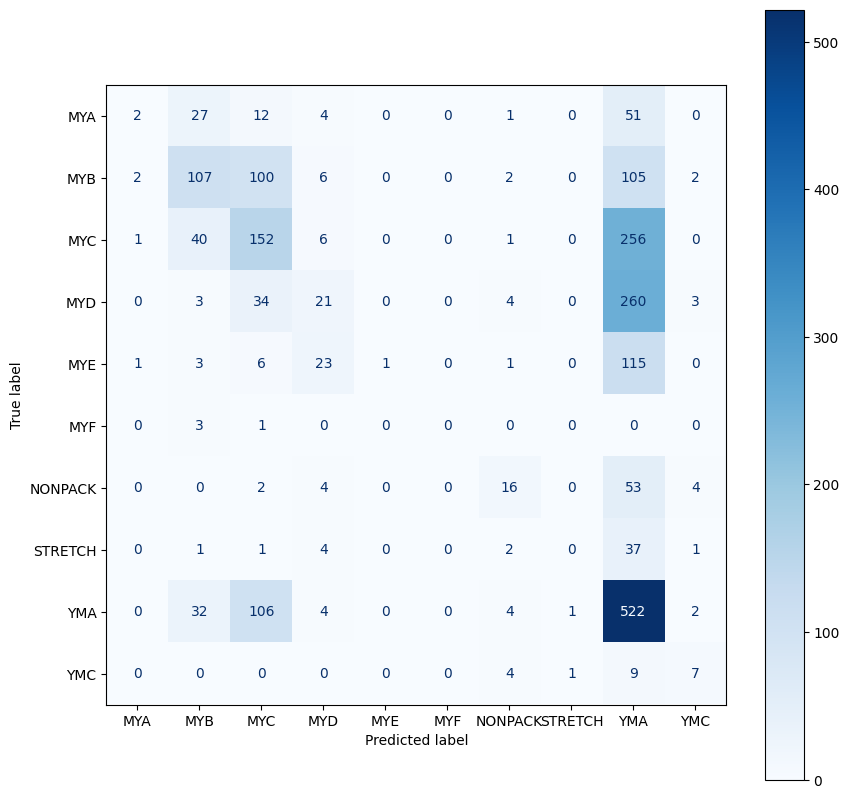

In [69]:
cm = confusion_matrix(y_test3, y_pred3)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels3)
fig, ax = plt.subplots(figsize=(10,10) )
cm_display.plot(ax=ax,cmap=plt.cm.Blues)

Достаточно много эементов лежит вне диагонали. А значит модель выбирает упаковку отличную от той, которую выбрал человек.
Разделим каждое значение в матрице неточностей по числу заказов. ЧТобы сравнивать частоты ошибок, вместо абсолютных значений.

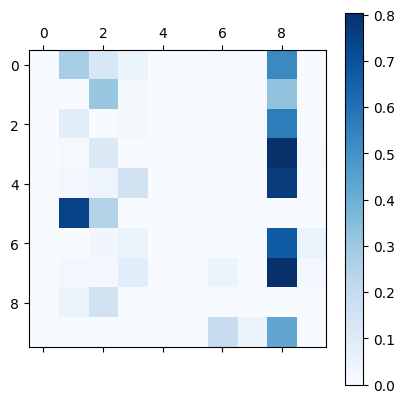

In [70]:
row_sums = cm.sum(axis=1, keepdims=True)
norm_conf_mx = cm / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.Blues)
plt.colorbar()

Очевидно, что большинство ошибок допущено  YMA.

In [71]:
mistakes3['y_test'].value_counts()

YMA        671
MYC        456
MYD        325
MYB        324
MYE        150
MYA         97
NONPACK     79
STRETCH     46
YMC         21
MYF          4
Name: y_test, dtype: int64

In [72]:
mistakes3['y_pred'].value_counts()

YMA        1408
MYC         414
MYB         216
MYD          72
NONPACK      35
YMC          19
MYA           6
STRETCH       2
MYE           1
Name: y_pred, dtype: int64

**Вывод по ошибкам с моделью, где участвуют 3 ску:** данных не чень много по таким заказам. ВОзможно требуется их собирать дополнительно. Или выводить подсказку по этому виду упаковки справочно.

Посмотрим на **ошибки у модели с выборкой по 2м видам sku**:

In [73]:
mistakes2 = pd.DataFrame()
mistakes2['y_test'] = df2['y_test']
mistakes2['y_pred'] = df2['y_pred']
conditions = [df2['y_test'] == df2['y_pred'], df2['y_test'] != df2['y_pred']]
choices = [0 , 1]
mistakes2['mistakes_'] = np.select(conditions, choices, default='Tie')
mistakes2['mistakes_'].value_counts()

1    2424
0    1903
Name: mistakes_, dtype: int64

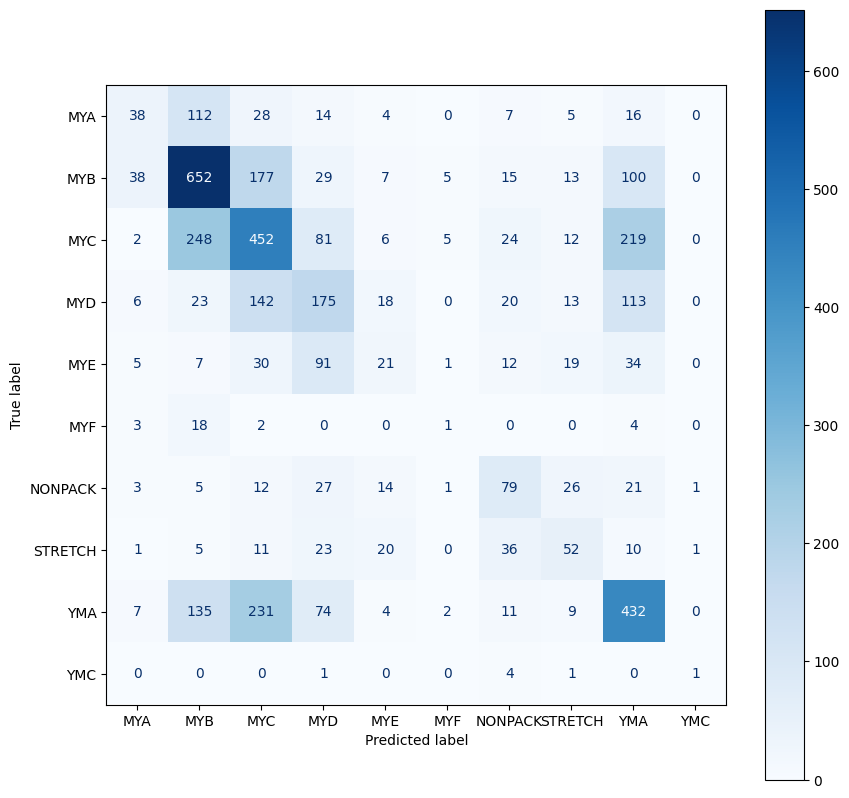

In [74]:
cm = confusion_matrix(y_test2, y_pred2)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels2)
fig, ax = plt.subplots(figsize=(10,10) )
cm_display.plot(ax=ax,cmap=plt.cm.Blues)

Достаточно много эементов лежит вне диагонали. А значит модель выбирает упаковку отличную от той, которую выбрал человек.
Разделим каждое значение в матрице неточностей по числу заказов. ЧТобы сравнивать частоты ошибок, вместо абсолютных значений.

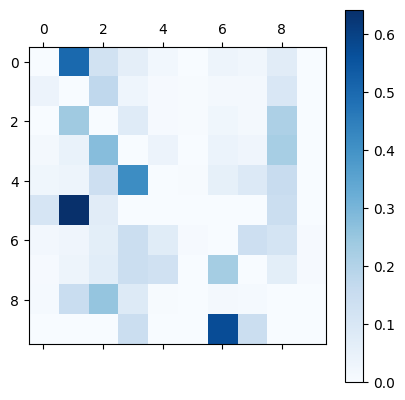

In [75]:
row_sums = cm.sum(axis=1, keepdims=True)
norm_conf_mx = cm / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.Blues)
plt.colorbar()

In [76]:
mistakes2['y_test'].value_counts()

MYC        1049
MYB        1036
YMA         905
MYD         510
MYA         224
MYE         220
NONPACK     189
STRETCH     159
MYF          28
YMC           7
Name: y_test, dtype: int64

In [77]:
mistakes2['y_pred'].value_counts()

MYB        1205
MYC        1085
YMA         949
MYD         515
NONPACK     208
STRETCH     150
MYA         103
MYE          94
MYF          15
YMC           3
Name: y_pred, dtype: int64

**Вывод по ошибкам с моделью, где участвуют 2 вида ску:** Часть заказов из пакетов алгоритм кладет в коробки. А часть заказов из коробок в пакеты. В связи с этим по итоге на бизнес метрике мы видим снижение объема. А на матрице ошибок смещения от диагональной линии.
У нас есть существенный дисбаланс классов по заказам. И либо нужно заточить модель под заказы до 5 кг. Либо увеличить объем данных для обучения.

Посмотрим на **ошибки у модели с выборкой по 1му видом sku**:

In [78]:
mistakes1 = pd.DataFrame()
mistakes1['y_test'] = df1['y_test']
mistakes1['y_pred'] = df1['y_pred']
conditions = [df1['y_test'] == df1['y_pred'], df1['y_test'] != df1['y_pred']]
choices = [0 , 1]
mistakes1['mistakes_'] = np.select(conditions, choices, default='Tie')
mistakes1['mistakes_'].value_counts()

0    16200
1    13361
Name: mistakes_, dtype: int64

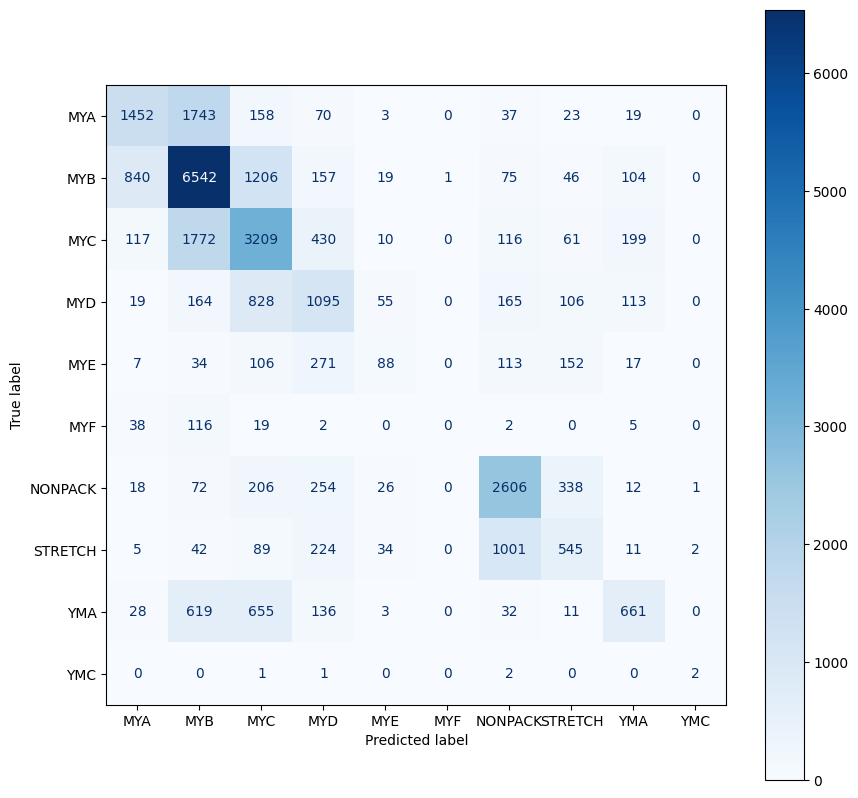

In [79]:
cm = confusion_matrix(y_test1, y_pred1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels2)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax,cmap=plt.cm.Blues)

Достаточно много эементов лежит вне диагонали. А значит модель выбирает упаковку отличную от той, которую выбрал человек.
Разделим каждое значение в матрице неточностей по числу заказов. ЧТобы сравнивать частоты ошибок, вместо абсолютных значений.

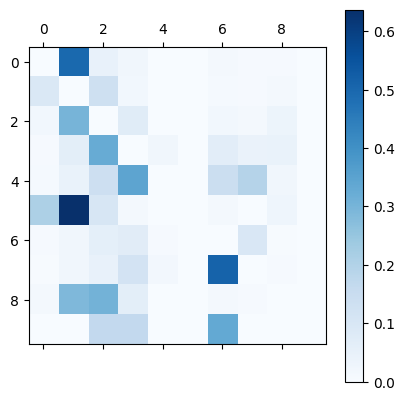

In [80]:
row_sums = cm.sum(axis=1, keepdims=True)
norm_conf_mx = cm / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.Blues)
plt.colorbar()

In [81]:
mistakes1['y_test'].value_counts()

MYB        8990
MYC        5914
NONPACK    3533
MYA        3505
MYD        2545
YMA        2145
STRETCH    1953
MYE         788
MYF         182
YMC           6
Name: y_test, dtype: int64

In [82]:
mistakes1['y_pred'].value_counts()

MYB        11104
MYC         6477
NONPACK     4149
MYD         2640
MYA         2524
STRETCH     1282
YMA         1141
MYE          238
YMC            5
MYF            1
Name: y_pred, dtype: int64

**Вывод по ошибкам с моделью, где участвуют 1 виду ску:** Достаточной большую часть ошибок на STRECH и NONPACK удастся устранить благодаря тому, что такие заказы будут обрабатываться вне ML.
У нас есть существенный дисбаланс классов по заказам. И либо нужно заточить модель под заказы до 5 кг. Либо увеличить объем данных для обучения.